# 2D Fourier Transform

In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
images = [ cv2.imread("./images/data/00{}.jpg".format(i), cv2.IMREAD_GRAYSCALE) for i in range(0, 7)] 

In [2]:
def fft2(img: np.array): 
    M, N = img.shape 
    fourier = np.matmul(exp_mu(img), np.matmul(img, exp_nu(img)) )
    return fourier

def inverse_fft2(img: np.array):
    M, N = img.shape 
    inv_fourier = np.matmul(exp_mu(img, inverse = True), np.matmul(img , exp_nu(img, inverse = True))) / (M * N)
    return inv_fourier

def highpass(img, radius = 45): 
    h, w = img.shape[0], img.shape[1]
    filtered = [[0 for _ in range(w)] for _ in range(h)]
    for i in range(h): 
        for j in range(w):
            distance = ((i - h // 2) ** 2 + (j - w // 2) ** 2)
            if distance < radius ** 2:
                continue 
            filtered[i][j] = img[i][j]
    return np.array(filtered)
    
    
def exp_mu(img: np.array, inverse = False):
    M = img.shape[0]
    result = [[0 for _ in range(M)] for _ in range(M)]
    for u in range(M):
        for m in range(M):
            if inverse:
                result[u][m] = np.exp(2j* np.pi * m * u / M )
            else: 
                result[u][m] = np.exp(-2j* np.pi * m * u / M )
    return np.array(result)

def exp_nu(img: np.array, inverse = True):
    N = img.shape[1]
    result = [[0 for _ in range(N)] for _ in range(N)]
    for v in range(N):
        for n in range(N):
            if inverse:
                result[v][n] = np.exp(2j* np.pi * n * v / N )
            else:
                result[v][n] = np.exp(-2j* np.pi * n * v / N )  
    return np.array(result)

def shift(img: np.array):    
    return np.fft.fftshift(img)

def fft_shift(img: np.array):
    return np.abs(shift(fft2())).round().astype(np.uint8)

def show(img: np.array):
    plt.imshow(fft_shift(img), cmap='gray')
    
def azimuthal_averaging(img: np.ndarray):
    h, w = img.shape 
    center = (h // 2, w // 2) 
    max_radius = np.hypot(center[0], center[1]) # max radius (distance from the center to the corner)
    if max_radius != int(max_radius): # if max_radius is not integer
        max_radius += 1
    max_radius = int(max_radius) 
    cum_sum_freq = np.array([0 for _ in range(max_radius)])
    pixels = np.array([0 for _ in range(max_radius)])
    for i in range(h):
        for j in range(w):
            radius = int(np.hypot(i - center[0], j - center[1]))   # distance from the center
            cum_sum_freq[radius] += img[i][j]
            pixels[radius] += 1
    cum_sum_freq = cum_sum_freq / pixels  # divide into the number of pixels
    cum_sum_freq = cum_sum_freq / max(cum_sum_freq) # averaging
    return cum_sum_freq
    

In [3]:
def pipeline(img, name, center = False,  suffix = ""): 
    h, w = img.shape
    if center:
        suffix = "_centered"
        img = img[np.ix_(range(h // 5 , 4 * h // 5), range(w // 5, 4 * w // 5))]
    print(img.shape)
        
    fft_img = fft2(img) 
    fft_shifted = np.fft.fftshift(fft_img)
    highpass_img = highpass(fft_shifted, radius = 45)
    plt.imshow(np.log(np.abs(highpass_img)), cmap='gray')
    plt.savefig("./images/frequency/00{}{}.jpg".format(name, suffix))
    plt.clf()
    
    inv_fft_img = inverse_fft2(highpass_img)
    plt.imshow(np.abs(inv_fft_img), cmap='gray')
    plt.savefig("./images/highpassed/00{}{}.jpg".format(name, suffix))
    plt.clf()
    
    return np.abs(inv_fft_img)
    

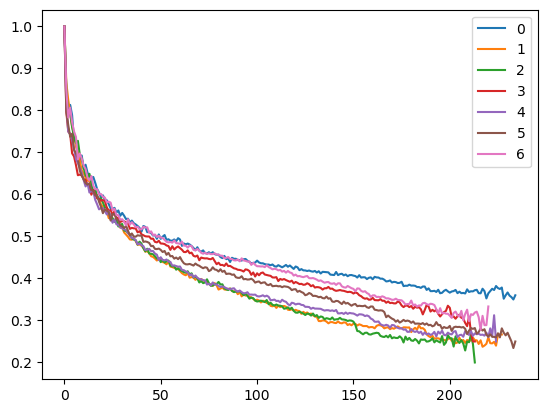

In [4]:

azs = []
for i in range(7):
    fft_img = np.log(np.abs(np.fft.fftshift(fft2(images[i]))))
    az = azimuthal_averaging(fft_img)
    azs.append(az)
    plt.plot(az)
plt.legend([i for i in range(7)])

In [14]:
centered_result = []
for i in range(7):
    img = pipeline(images[i], i, center = True)
    img = img * 255 / img.max()
    centered_result.append(img)
    print(img.max())

centered_res = [] 

for img in centered_result: 
    h, w = img.shape 
    val = 0
    for i in range(h):
        for j in range(w):
            val += img[i][j] * np.exp(-np.sqrt((i - h // 2) ** 2 +  (j - w // 2) ** 2))
            
    centered_res.append(val)

centered_res

(199, 199)


/var/folders/x1/tylp6nfj5xnb74kpdk36gzzw0000gn/T/ipykernel_43385/785651123.py:11: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(highpass_img)), cmap='gray')


254.99999999999997
(225, 156)
255.0
(181, 181)
255.0
(183, 179)
255.0
(191, 191)
255.0
(199, 199)
255.00000000000003
(189, 185)
255.0


[18.959443089582585,
 18.248273291492268,
 19.348377226616414,
 58.27144064226741,
 35.863293626646126,
 14.15998278754107,
 87.77418806987959]

<Figure size 640x480 with 0 Axes>

In [11]:
centered_res = [] 

for img in centered_result: 
    h, w = img.shape 
    val = 0
    for i in range(h):
        for j in range(w):
            # val += img[i][j] * np.exp(-np.sqrt((i - h // 2) ** 2 +  (j - w // 2) ** 2))
            val += img[i][j]
            
    centered_res.append(val)

In [12]:
centered_res

[258582.98517842652,
 251062.51805499414,
 293519.9639968446,
 443158.3213076284,
 265301.18361503346,
 168925.69009573187,
 405971.2135000135]

In [77]:
eye_cropped = [
    images[0][np.ix_(range(85, 140), range(70, 250))],
    images[1][np.ix_(range(125, 160), range(0, 160))],
    images[2][np.ix_(range(90, 120), range(75, 220))],
    images[3][np.ix_(range(85, 120), range(80, 220))],
    images[4][np.ix_(range(85, 130), range(80, 250))],
    images[5][np.ix_(range(90, 140), range(80, 250))],
    images[6][np.ix_(range(90, 13), range(80, 230))]
]

In [83]:
a = cv2.resize(images[0], (200, 200))


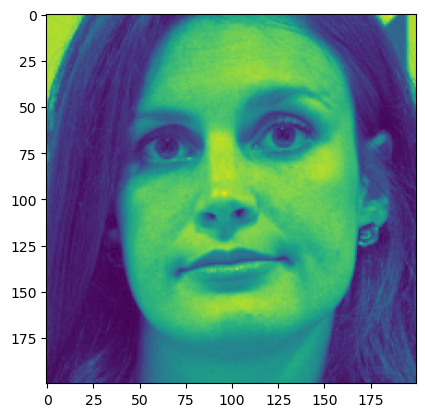

In [84]:
plt.imshow(a)

In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="1kH73FLzbXNb82H4tFtv")
project = rf.workspace().project("eye-detection-fnwhr")
model = project.version(2).model

# infer on a local image
print(model.predict(images[0], confidence=40, overlap=30).json())

# visualize your prediction
# model.predict("your_image.jpg", confidence=40, overlap=30).save("prediction.jpg")

# infer on an image hosted elsewhere
# print(model.predict("URL_OF_YOUR_IMAGE", hosted=True, confidence=40, overlap=30).json())

ModuleNotFoundError: No module named 'roboflow'